## จับบบรรทัด

Lines detected: [(107, 137), (182, 212)]


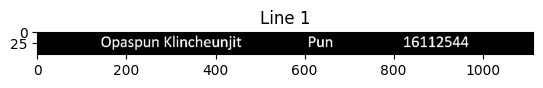

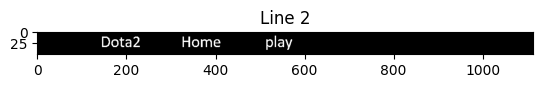

Saved lines to ..\data\output_images\output_lines


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_lines")
output_folder.mkdir(exist_ok=True)

# โหลดภาพ
#image = cv2.imread("../data/test_images/line_detection/test_a_to_z_3.jpg")
#image = cv2.imread("../data/test_images/line_detection/testAtoZ_1.jpg")
#image = cv2.imread("../data/test_images/line_detection/0to9_2.jpg")
#image = cv2.imread("../data/test_images/transcript/Transcript_page-0001.jpg")
image = cv2.imread("../data/test_images/word_images/word_3.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

# คำนวณ Histogram Projection
horizontal_projection = np.sum(binary_image, axis=1)  # รวมพิกเซลในแนวนอน

threshold_value = 200  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
line_indices = np.where(horizontal_projection > threshold_value)[0]

# แยกช่วงตำแหน่งแต่ละบรรทัด
lines = []
start_idx = None

for i in range(len(line_indices) - 1):
    if start_idx is None:
        start_idx = line_indices[i]
    if line_indices[i+1] > line_indices[i] + 1:  # เจอช่วงว่างระหว่างบรรทัด
        end_idx = line_indices[i]
        lines.append((start_idx, end_idx))
        start_idx = None
if start_idx is not None:
    lines.append((start_idx, line_indices[-1]))

print("Lines detected:", lines)

# แยกบรรทัดและเพิ่ม Padding
line_images = []
padding = 10  # ระบุ Padding

for start, end in lines:
    padded_start = max(0, start - padding)
    padded_end = min(binary_image.shape[0], end + padding)
    line_img = binary_image[padded_start:padded_end, :]
    line_images.append(line_img)

for idx, line_img in enumerate(line_images):
    file_path = output_folder / f"line_{idx + 1}.png"
    cv2.imwrite(str(file_path), line_img)
    plt.figure()
    plt.imshow(line_img, cmap="gray")
    plt.title(f"Line {idx + 1}")
    plt.show()
print(f"Saved lines to {output_folder}")


## จับข้อความในบรรทัด

[[(145, 458), (611, 662), (825, 968)], [(146, 230), (327, 411), (515, 572)]]
line : 1
  text : 1 515 572
  text : 2 515 572
  text : 3 515 572
line : 2
  text : 1 515 572
  text : 2 515 572
  text : 3 515 572


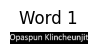

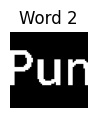

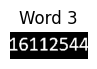

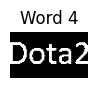

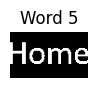

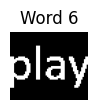

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def histogram_projection(images, distance):
    # คำนวณ Histogram Projection
    horizontal_projection = np.sum(images, axis=0)  # รวมพิกเซลในแนวนอน
    threshold_value = 100  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
    column_indices = np.where(horizontal_projection > threshold_value)[0]

    # แยกช่วงตำแหน่งแต่ละบรรทัด
    columns = []
    start_idx = None

    for i in range(len(column_indices) - 1):
        if start_idx is None:
            start_idx = column_indices[i]
        if column_indices[i + 1] > column_indices[i] + distance:  # เจอช่องว่างระหว่างคอลัมน์
            end_idx = column_indices[i]
            columns.append((start_idx, end_idx))
            start_idx = None
    if start_idx is not None:
        columns.append((start_idx, column_indices[-1]))

    #plt.plot(horizontal_projection)
    #plt.title("Horizontal Projection")
    #plt.show()

    return columns


# แยกข้อความในแต่ละบรรทัด
text_start_end = []
for idx, line_image in enumerate(line_images):
    text_start_end.append(histogram_projection(line_image, 15))

print(text_start_end)

# แยกคำออกมาจากข้อความ
text_images = []
#line_text_image
for idx_line, line_img in enumerate(line_images):
    print("line :", idx_line+1)
    for idx, text in enumerate(text_start_end[idx_line]):
        start_col = text[0]
        end_col = text[1]
        print("  text :", idx+1, start, end)
        word_img = line_img[:, start_col:end_col]
        text_images.append(word_img)



for idx, text_img in enumerate(text_images):
    plt.figure(figsize=(1, 1))
    plt.imshow(text_img, cmap="gray")
    plt.title(f"Word {idx + 1}")
    plt.axis("off")
    plt.show()
